In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical


In [2]:
# Path to dataset recordings
dataset_path = "/kaggle/input/free-spoken-digit-dataset-fsdd/recordings"

# Get list of audio files
audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]
print(f"Total audio files: {len(audio_files)}")


Total audio files: 3000


In [3]:
def extract_features(file_path, max_length=50):
    audio, sr = librosa.load(file_path, sr=None)  # Load audio file
    n_fft = min(len(audio), 1024)  # Adjust n_fft to avoid warnings

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, n_fft=n_fft)  # Extract MFCC features

    # Pad or truncate sequences to a fixed length
    if mfccs.shape[1] < max_length:
        pad_width = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_length]

    return mfccs


In [4]:
X, y = [], []

for file in audio_files:
    label = int(file.split('_')[0])  # Extract digit label from filename
    file_path = os.path.join(dataset_path, file)
    features = extract_features(file_path)
    X.append(features)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Reshape data to match CNN input
X = X[..., np.newaxis]  # Add channel dimension

# Convert labels to categorical format (one-hot encoding)
y = to_categorical(y, num_classes=10)

print(f"Shape of features: {X.shape}, Shape of labels: {y.shape}")


Shape of features: (3000, 40, 50, 1), Shape of labels: (3000, 10)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (2400, 40, 50, 1), Test set: (600, 40, 50, 1)


In [6]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 50, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes for digits 0-9
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 11, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5632)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         721,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 741,130 (2.83 MB)

 Trainable params: 741,130 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.1395 - loss: 3.1981 - val_accuracy: 0.3067 - val_loss: 2.0731
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2802 - loss: 1.9921 - val_accuracy: 0.6783 - val_loss: 1.2605
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4762 - loss: 1.4084 - val_accuracy: 0.8433 - val_loss: 0.7406
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6674 - loss: 0.9576 - val_accuracy: 0.9233 - val_loss: 0.3753
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7596 - loss: 0.6867 - val_accuracy: 0.9483 - val_loss: 0.2562
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8304 - loss: 0.4884 - val_accuracy: 0.9550 - val_loss: 0.2242
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8521 - loss: 0.4233 - val_accuracy: 0.9633 - val_loss: 0.1704
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8727 - loss: 0.3506 - val_accuracy: 0.9733 - v

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9709 - loss: 0.1296
Test Accuracy: 0.98


In [9]:
def predict_digit(file_path):
    features = extract_features(file_path)
    features = np.expand_dims(features, axis=0)  # Add batch dimension
    features = np.expand_dims(features, axis=-1)  # Add channel dimension
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction)
    return predicted_label

sample_file = os.path.join(dataset_path, audio_files[0])
print(f"Predicted digit: {predict_digit(sample_file)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted digit: 0


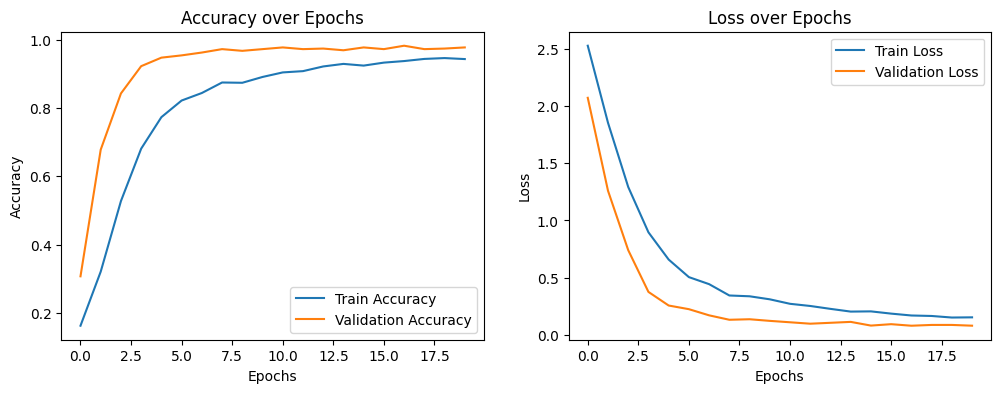

In [10]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()
